# Data Re-Uploading on a binary linear set

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np


from scipy.sparse.linalg import expm
from scipy.sparse import coo_matrix, csc_matrix, diags, identity


import jax.numpy as jnp
from jax import grad, vmap, jit
from jax import random

import jax

import scipy

from tqdm import tqdm

from sklearn.utils import shuffle

import qutip as q

from tqdm import tqdm

from bloch_3d_plot import plot_bloch



from sklearn.model_selection import train_test_split


We again first define the spin matrices and the functions that act on a state. I will use a spin length of 4 which yields 9 states. I will use every second qudit state to label the digits.

In [2]:
l = 1/2 # spin length

# let's put together spin matrices
dim_qudit = 2*l+1
qudit_range = np.arange(l, -(l+1),-1)

Id  =  scipy.sparse.csc_matrix(identity(dim_qudit))
Lx  =  scipy.sparse.csc_matrix(1/2*diags([np.sqrt([(l-m+1)*(l+m) for m in qudit_range[:-1]]), np.sqrt([(l+m+1)*(l-m) for m in qudit_range[1:]]) ], [-1, 1]))
Lz  =  scipy.sparse.csc_matrix(diags([qudit_range], [0]))
Lz2 = Lz.multiply(Lz)
Lx2 = Lx.multiply(Lx)

Lx = Lx.toarray()
Lz = Lz.toarray()
Lz2 = Lz2.toarray()


Lx = jnp.array(Lx)
Lz = jnp.array(Lz)
Lz2 = jnp.array(Lz2)

In [3]:
def Rx(psi, theta, conj=False):
    Ux = jax.scipy.linalg.expm(-1j*theta*Lx)
    psi = jnp.dot(Ux,psi)
    return psi

def Rz(psi, theta, conj=False):
    Uz = jax.scipy.linalg.expm(-1j*theta*Lz)
    psi = jnp.dot(Uz,psi)
    return psi

def Rz2(psi, theta, conj=False):
    Uz2 = jax.scipy.linalg.expm(-1j*theta*Lz2)
    psi = jnp.dot(Uz2,psi)
    return psi

def Initialization(psi :np.array, x1: float, x2: float)-> np.array:
    psi = Rx(psi, x1)
    psi = Rz(psi, x2)
    return psi


def varaince_z(psi):
    a = psi.T.conj()@Lz@psi
    b = psi.T.conj()@Lz**2@psi
    
    return jnp.abs((b-a**2).real)

def measure(psi):
    prob = psi**2
    measurement = np.random.choice(np.arange(len(state)), p=prob)
    return measurement

def expect(psi, oper):
    return (psi.T.conj()@oper@psi).real



In [4]:
state_labels = [[0], [-1]]


def cost_circ(params, x, y, return_ind, state_labels=state_labels):

    overlap = circ(params, x, y)
    loss_overlap =(1 - overlap**2)

   
    return loss_overlap 


def circ(params, x, y, var_return=False):

    psi = 1j*jnp.zeros(int(l*2+1))
    #This is necessary since jnp arrays are immutable
    psi = jax.ops.index_add(psi, 0, 1+1j*0)
    
    label = 1j*jnp.zeros(int(l*2+1))
    #This is necessary since jnp arrays are immutable
    label = jax.ops.index_add(label, y, 1+1j*0)

    for i in range(0, len(params)):
    
        psi = Initialization(psi, x[0], x[1])
    
        psi = Rx(psi, params[i][0]) 
        
        psi = Rz(psi, params[i][1])
        
        psi = Rx(psi, params[i][2]) 

    
    if var_return:
        return  jnp.abs(jnp.dot(psi, label)), psi
    return jnp.abs(jnp.dot(psi, label))


def test(params, x, state_labels=state_labels):

    fidelities = jnp.array([circ(params, x, dm[0]) for dm in state_labels])
    
    best_fidel = jnp.argmax(fidelities)


    return best_fidel

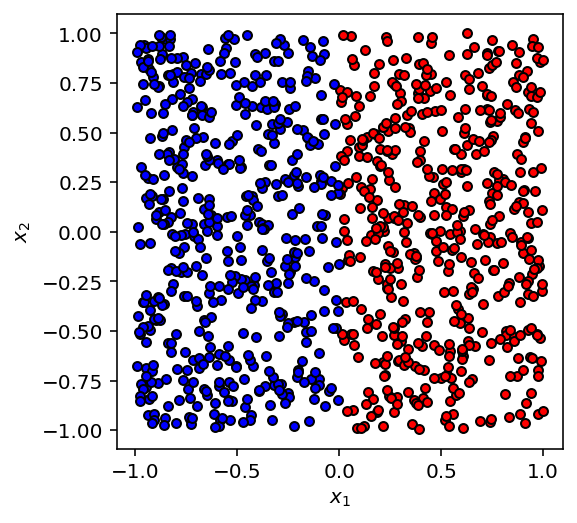

In [5]:
def accuracy_score(y_true, y_pred):

    score = y_true == y_pred
    return score.sum() / len(y_true)



def generate_data(samples, horiz=False):

    np.random.seed(42)
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if horiz:
            lin = x[1]
        else:
            lin = x[0]
        if lin < 0:
            y = -1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)


def plot_data(x, y, fig=None, ax=None, title=None):

    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == -1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(title)


Xdata, ydata = generate_data(1000, horiz=False)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)

def iterate_minibatches(inputs, targets, batch_size):

    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

Th following functions are the jitted, vectorized versions of the cost and test function.

In [6]:
@jit
def vmap_cost(params, X_batched, y_batched, beta=0.3):
    return vmap(cost_circ,  in_axes=(None, 0, 0, None, None))(params, X_batched, y_batched, beta, False).sum()/len(X_batched)

@jit
def vmap_cost_ind(params, X_batched, y_batched, beta=0.3):
    return vmap(cost_circ,  in_axes=(None, 0, 0, None, None))(params, X_batched, y_batched, beta, True)

@jit
def vmap_test(params, X_batched, state_labels):
    return vmap(test,  in_axes=(None, 0, None))(params, X_batched, state_labels)



We then need the gradient of the cost function.

In [7]:
cost_circ_grad = grad(vmap_cost, argnums=0)

Now we have everything we need and can start learning. We first need to create the dataset and choose random parameters to start. 

In [8]:
x_data, y_data = generate_data(1000)

batch_size = 100

num_layers = 1

num_params = 3

x_data, y_data = shuffle(x_data, y_data)


train_x, test_x, train_y, test_y = train_test_split(x_data, y_data)
state_labels_flat = np.array(state_labels).flatten()

--------------------------------------
Starting Learning with 2 layer(s)!
Starting Epoch 1, learning rate: 0.10
Epoch 1, Loss: 0.222, Accuracy: 0.928
Starting Epoch 2, learning rate: 0.10
Epoch 2, Loss: 0.213, Accuracy: 0.860
Starting Epoch 3, learning rate: 0.10
Epoch 3, Loss: 0.165, Accuracy: 0.920
Starting Epoch 4, learning rate: 0.10
Epoch 4, Loss: 0.151, Accuracy: 0.956
Starting Epoch 5, learning rate: 0.10
Epoch 5, Loss: 0.156, Accuracy: 0.960
Starting Epoch 6, learning rate: 0.10
Epoch 6, Loss: 0.143, Accuracy: 0.984
Starting Epoch 7, learning rate: 0.10
Epoch 7, Loss: 0.145, Accuracy: 0.972
Starting Epoch 8, learning rate: 0.10
Epoch 8, Loss: 0.142, Accuracy: 0.988
Starting Epoch 9, learning rate: 0.10
Epoch 9, Loss: 0.143, Accuracy: 0.992
Starting Epoch 10, learning rate: 0.10
Epoch 10, Loss: 0.142, Accuracy: 0.984
Starting Epoch 11, learning rate: 0.10
Epoch 11, Loss: 0.141, Accuracy: 0.984
Starting Epoch 12, learning rate: 0.10
Epoch 12, Loss: 0.142, Accuracy: 0.984
Starting

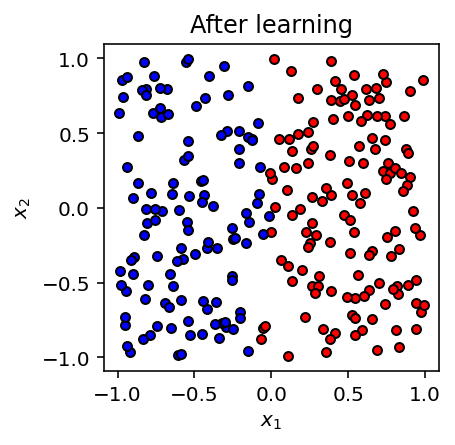

In [10]:
num_layers_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]


for num_layer in num_layers_list:
    print("--------------------------------------")
    print(f"Starting Learning with {num_layer} layer(s)!")
    np.random.seed(42)
    params = np.random.uniform(size=(num_layer, num_params))*np.pi/2


    pred_pre = vmap_test(params, train_x, state_labels=state_labels)
    pred_pre = np.array(pred_pre)
    pred_pre = np.array(pred_pre)
    for n, prediction in enumerate(pred_pre):
        pred_pre[n] = state_labels_flat[prediction]

    

    beta=0

    losses = []
    train_acc = []
    param_list = []

    epochs = 20

    learning_rate = 0.1
    opt = AdamOptimizer(learning_rate)

    for i in range(epochs):
        #print("--------------------------------------")
        print(f"Starting Epoch {i+1}, learning rate: {learning_rate:.2f}")

        x_train, y_train = shuffle(train_x, train_y)
        for X_Batch, Y_Batch in iterate_minibatches(x_train, y_train, batch_size):
            #print(X_Batch.shape, Y_Batch.shape)
            params = opt.step(vmap_cost, params, grad_fn=cost_circ_grad, X_batched=X_Batch, y_batched=Y_Batch)
        param_list.append(params)
        pred_test = vmap_test(params, test_x, state_labels)
        pred_test = np.array(pred_test)
        for n, prediction in enumerate(pred_test):
            pred_test[n] = used_labels_arr[prediction]
        acc = accuracy_score(test_y, pred_test)
        loss = vmap_cost(params, train_x, train_y)


        losses.append(loss)
        train_acc.append(acc)
        print(f"Epoch {i+1}, Loss: {loss:.3f}, Accuracy: {acc:.3f}")
        #print(params)
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    plot_data(test_x, pred_test, title="After learning", fig=fig, ax=ax)
    plt.show()
    np.save(f"Bin_Lin/params_{num_layer}-layers.npy", param_list)
    np.save(f"Bin_Lin/loss_{num_layer}-layers.npy", losses)
    np.save(f"Bin_Lin/acc_{num_layer}-layers.npy", train_acc)










In [14]:
num_layers_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
np.random.seed(2)




batch_size = 50

num_params = 3


for num_layer in num_layers_list:

    for j in tqdm(range(20)):
        x_data, y_data = generate_data(1000)
        x_data, y_data = shuffle(x_data, y_data)
        train_x, test_x, train_y, test_y = train_test_split(x_data, y_data)
        
        print("--------------------------------------")
        print(f"Starting Learning with {num_layer} layer(s)!")

        params = np.random.uniform(size=(num_layer, num_params))*np.pi/2


        beta=0

        losses = []
        train_acc = []
        param_list = []

        epochs = 20

        learning_rate = 0.05
        opt = AdamOptimizer(learning_rate)

        for i in range(epochs):
            #print("--------------------------------------")
            #print(f"Starting Epoch {i+1}, learning rate: {learning_rate:.2f}")

            x_train, y_train = shuffle(train_x, train_y)
            for X_Batch, Y_Batch in iterate_minibatches(x_train, y_train, batch_size):
                #print(X_Batch.shape, Y_Batch.shape)
                params = opt.step(vmap_cost, params, grad_fn=cost_circ_grad, X_batched=X_Batch, y_batched=Y_Batch)
            param_list.append(params)
            pred_test = vmap_test(params, test_x, state_labels)
            pred_test = np.array(pred_test)
            for n, prediction in enumerate(pred_test):
                pred_test[n] = state_labels_flat[prediction]
            acc = accuracy_score(test_y, pred_test)
            loss = vmap_cost(params, train_x, train_y)


            losses.append(loss)
            train_acc.append(acc)
            #print(f"Epoch {i+1}, Loss: {loss:.3f}, Accuracy: {acc:.3f}")
            #print(params)

        np.save(f"Bin_Lin_correct/params_{num_layer}-layers-{j}.npy", param_list)
        np.save(f"Bin_Lin_correct/loss_{num_layer}-layers-{j}.npy", losses)
        np.save(f"Bin_Lin_correct/acc_{num_layer}-layers-{j}.npy", train_acc)




  0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------
Starting Learning with 1 layer(s)!


  5%|▌         | 1/20 [00:03<01:07,  3.58s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 10%|█         | 2/20 [00:07<01:09,  3.84s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 15%|█▌        | 3/20 [00:10<01:00,  3.56s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 20%|██        | 4/20 [00:14<00:54,  3.42s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 25%|██▌       | 5/20 [00:17<00:52,  3.50s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 30%|███       | 6/20 [00:22<00:55,  3.99s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 35%|███▌      | 7/20 [00:26<00:50,  3.89s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 40%|████      | 8/20 [00:30<00:47,  3.93s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 45%|████▌     | 9/20 [00:33<00:41,  3.74s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 50%|█████     | 10/20 [00:36<00:36,  3.62s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 55%|█████▌    | 11/20 [00:40<00:31,  3.49s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 60%|██████    | 12/20 [00:43<00:27,  3.41s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 65%|██████▌   | 13/20 [00:46<00:23,  3.35s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 70%|███████   | 14/20 [00:49<00:20,  3.35s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 75%|███████▌  | 15/20 [00:53<00:16,  3.29s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 80%|████████  | 16/20 [00:56<00:13,  3.28s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 85%|████████▌ | 17/20 [00:59<00:09,  3.26s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 90%|█████████ | 18/20 [01:02<00:06,  3.24s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


 95%|█████████▌| 19/20 [01:05<00:03,  3.21s/it]

--------------------------------------
Starting Learning with 1 layer(s)!


  0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------
Starting Learning with 2 layer(s)!


  5%|▌         | 1/20 [00:27<08:33, 27.01s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 10%|█         | 2/20 [00:33<04:27, 14.88s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 15%|█▌        | 3/20 [00:39<03:07, 11.01s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 20%|██        | 4/20 [00:45<02:22,  8.90s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 25%|██▌       | 5/20 [00:51<01:55,  7.69s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 30%|███       | 6/20 [00:56<01:38,  7.00s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 35%|███▌      | 7/20 [01:02<01:24,  6.53s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 40%|████      | 8/20 [01:08<01:15,  6.30s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 45%|████▌     | 9/20 [01:13<01:06,  6.06s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 50%|█████     | 10/20 [01:19<00:59,  5.92s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 55%|█████▌    | 11/20 [01:24<00:52,  5.81s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 60%|██████    | 12/20 [01:30<00:47,  5.94s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 65%|██████▌   | 13/20 [01:36<00:40,  5.85s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 70%|███████   | 14/20 [01:42<00:34,  5.78s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 75%|███████▌  | 15/20 [01:47<00:28,  5.74s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 80%|████████  | 16/20 [01:53<00:22,  5.71s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 85%|████████▌ | 17/20 [01:59<00:17,  5.68s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 90%|█████████ | 18/20 [02:04<00:11,  5.63s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


 95%|█████████▌| 19/20 [02:10<00:05,  5.63s/it]

--------------------------------------
Starting Learning with 2 layer(s)!


  0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------
Starting Learning with 3 layer(s)!


  5%|▌         | 1/20 [00:45<14:19, 45.22s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 10%|█         | 2/20 [00:55<07:24, 24.71s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 15%|█▌        | 3/20 [01:05<05:07, 18.11s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 20%|██        | 4/20 [01:14<03:49, 14.36s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 25%|██▌       | 5/20 [01:22<03:02, 12.14s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 30%|███       | 6/20 [01:32<02:37, 11.23s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 35%|███▌      | 7/20 [01:42<02:21, 10.85s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 40%|████      | 8/20 [01:51<02:04, 10.40s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 45%|████▌     | 9/20 [02:01<01:51, 10.10s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 50%|█████     | 10/20 [02:10<01:38,  9.84s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 55%|█████▌    | 11/20 [02:20<01:28,  9.86s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 60%|██████    | 12/20 [02:29<01:17,  9.75s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 65%|██████▌   | 13/20 [02:39<01:07,  9.63s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 70%|███████   | 14/20 [02:48<00:56,  9.47s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 75%|███████▌  | 15/20 [02:58<00:48,  9.69s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 80%|████████  | 16/20 [03:06<00:37,  9.35s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 85%|████████▌ | 17/20 [03:17<00:28,  9.57s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 90%|█████████ | 18/20 [03:25<00:18,  9.23s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


 95%|█████████▌| 19/20 [03:34<00:09,  9.28s/it]

--------------------------------------
Starting Learning with 3 layer(s)!


  0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------
Starting Learning with 4 layer(s)!


  5%|▌         | 1/20 [01:01<19:23, 61.22s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 10%|█         | 2/20 [01:15<10:02, 33.48s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 15%|█▌        | 3/20 [01:29<06:56, 24.52s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 20%|██        | 4/20 [01:42<05:19, 19.96s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 25%|██▌       | 5/20 [01:54<04:20, 17.35s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 30%|███       | 6/20 [02:08<03:44, 16.04s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 35%|███▌      | 7/20 [02:21<03:18, 15.25s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 40%|████      | 8/20 [02:34<02:52, 14.37s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 45%|████▌     | 9/20 [02:47<02:33, 13.99s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 50%|█████     | 10/20 [03:00<02:17, 13.76s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 55%|█████▌    | 11/20 [03:13<02:01, 13.48s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 60%|██████    | 12/20 [03:27<01:47, 13.44s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 65%|██████▌   | 13/20 [03:39<01:32, 13.25s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 70%|███████   | 14/20 [03:52<01:17, 12.97s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 75%|███████▌  | 15/20 [04:03<01:03, 12.60s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 80%|████████  | 16/20 [04:16<00:50, 12.51s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 85%|████████▌ | 17/20 [04:28<00:37, 12.37s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 90%|█████████ | 18/20 [04:40<00:24, 12.34s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


 95%|█████████▌| 19/20 [04:53<00:12, 12.49s/it]

--------------------------------------
Starting Learning with 4 layer(s)!


  0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------
Starting Learning with 5 layer(s)!


  5%|▌         | 1/20 [01:20<25:28, 80.46s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 10%|█         | 2/20 [01:36<12:42, 42.39s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 15%|█▌        | 3/20 [01:51<08:27, 29.86s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 20%|██        | 4/20 [02:09<06:42, 25.13s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 25%|██▌       | 5/20 [02:24<05:25, 21.73s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 30%|███       | 6/20 [02:40<04:37, 19.82s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 35%|███▌      | 7/20 [02:56<04:01, 18.59s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 40%|████      | 8/20 [03:13<03:34, 17.87s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 45%|████▌     | 9/20 [03:29<03:11, 17.40s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 50%|█████     | 10/20 [03:44<02:46, 16.64s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 55%|█████▌    | 11/20 [03:59<02:26, 16.23s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 60%|██████    | 12/20 [04:13<02:02, 15.33s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 65%|██████▌   | 13/20 [04:26<01:43, 14.81s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 70%|███████   | 14/20 [04:40<01:26, 14.35s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 75%|███████▌  | 15/20 [04:53<01:10, 14.18s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 80%|████████  | 16/20 [05:07<00:56, 14.02s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 85%|████████▌ | 17/20 [05:20<00:41, 13.79s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 90%|█████████ | 18/20 [05:34<00:27, 13.76s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


 95%|█████████▌| 19/20 [05:47<00:13, 13.61s/it]

--------------------------------------
Starting Learning with 5 layer(s)!


  0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------
Starting Learning with 6 layer(s)!


  5%|▌         | 1/20 [01:17<24:30, 77.41s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 10%|█         | 2/20 [01:33<12:27, 41.54s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 15%|█▌        | 3/20 [01:50<08:34, 30.28s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 20%|██        | 4/20 [02:07<06:36, 24.81s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 25%|██▌       | 5/20 [02:23<05:26, 21.76s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 30%|███       | 6/20 [02:40<04:41, 20.10s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 35%|███▌      | 7/20 [02:56<04:06, 18.94s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 40%|████      | 8/20 [03:13<03:38, 18.18s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 45%|████▌     | 9/20 [03:30<03:15, 17.76s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 50%|█████     | 10/20 [03:46<02:53, 17.36s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 55%|█████▌    | 11/20 [04:03<02:33, 17.09s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 60%|██████    | 12/20 [04:20<02:16, 17.00s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 65%|██████▌   | 13/20 [04:36<01:58, 16.94s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 70%|███████   | 14/20 [04:56<01:46, 17.81s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 75%|███████▌  | 15/20 [05:18<01:34, 18.91s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 80%|████████  | 16/20 [05:35<01:14, 18.53s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 85%|████████▌ | 17/20 [05:56<00:57, 19.25s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 90%|█████████ | 18/20 [06:20<00:41, 20.53s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


 95%|█████████▌| 19/20 [06:37<00:19, 19.56s/it]

--------------------------------------
Starting Learning with 6 layer(s)!


  0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------
Starting Learning with 7 layer(s)!


  5%|▌         | 1/20 [01:37<30:45, 97.15s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 10%|█         | 2/20 [01:57<15:36, 52.03s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 15%|█▌        | 3/20 [02:17<10:32, 37.21s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 20%|██        | 4/20 [02:39<08:20, 31.26s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 25%|██▌       | 5/20 [03:05<07:19, 29.29s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 30%|███       | 6/20 [03:30<06:31, 27.96s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 35%|███▌      | 7/20 [03:53<05:41, 26.24s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 40%|████      | 8/20 [04:12<04:46, 23.88s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 45%|████▌     | 9/20 [04:30<04:05, 22.30s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 50%|█████     | 10/20 [04:49<03:32, 21.21s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 55%|█████▌    | 11/20 [05:09<03:06, 20.69s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 60%|██████    | 12/20 [05:27<02:40, 20.10s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 65%|██████▌   | 13/20 [05:46<02:17, 19.71s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 70%|███████   | 14/20 [06:08<02:01, 20.29s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 75%|███████▌  | 15/20 [06:28<01:41, 20.23s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 80%|████████  | 16/20 [06:48<01:20, 20.11s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 85%|████████▌ | 17/20 [07:09<01:01, 20.60s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 90%|█████████ | 18/20 [07:32<00:42, 21.30s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


 95%|█████████▌| 19/20 [07:57<00:22, 22.41s/it]

--------------------------------------
Starting Learning with 7 layer(s)!


  0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------
Starting Learning with 8 layer(s)!


  5%|▌         | 1/20 [01:48<34:18, 108.35s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 10%|█         | 2/20 [02:11<17:25, 58.06s/it] 

--------------------------------------
Starting Learning with 8 layer(s)!


 15%|█▌        | 3/20 [02:34<11:58, 42.29s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 20%|██        | 4/20 [03:01<09:35, 36.00s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 25%|██▌       | 5/20 [03:34<08:45, 35.05s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 30%|███       | 6/20 [04:01<07:32, 32.30s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 35%|███▌      | 7/20 [04:25<06:23, 29.46s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 40%|████      | 8/20 [04:53<05:48, 29.06s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 45%|████▌     | 9/20 [05:20<05:14, 28.59s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 50%|█████     | 10/20 [05:46<04:38, 27.82s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 55%|█████▌    | 11/20 [06:12<04:05, 27.24s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 60%|██████    | 12/20 [06:37<03:30, 26.33s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 65%|██████▌   | 13/20 [07:01<03:01, 25.88s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 70%|███████   | 14/20 [07:24<02:30, 25.03s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 75%|███████▌  | 15/20 [07:47<02:01, 24.38s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 80%|████████  | 16/20 [08:10<01:34, 23.73s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 85%|████████▌ | 17/20 [08:33<01:10, 23.51s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 90%|█████████ | 18/20 [08:55<00:46, 23.33s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


 95%|█████████▌| 19/20 [09:22<00:24, 24.39s/it]

--------------------------------------
Starting Learning with 8 layer(s)!


  0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------
Starting Learning with 9 layer(s)!


  0%|          | 0/20 [00:02<?, ?it/s]


KeyboardInterrupt: 